For building our final model we will be leveraging a package called Catboost which works with categorical data without encoding them. <br>
CatBoost is a recently open-sourced machine learning algorithm from Yandex.It is the successor of the MatrixNet algorithm.<br>
It is especially powerful in two ways:<br>
    1. It yields state-of-the-art results without extensive data training typically required by other machine learning methods
    2. Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.
“CatBoost” name comes from two words “Category” and “Boosting”.



In [1]:
### catboost installation
## !pip install catboost

## Importing necessary python packahes
import os
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import r2_score

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from time import time

RANDOM_STATE = 32

### Data Read-in

In [2]:
# Create Root Directory
rootDirectory = str(os.path.abspath('..'))

# Change Directory to data/raw
os.chdir("{}/data".format(rootDirectory))
print(os.getcwd())

C:\Users\rtilekar\Desktop\AirBnB_challenge\AirBnbPrediction\data


In [7]:
## Import the training interim file which is an output of the Data processing program
train_raw = pd.read_csv(rootDirectory + "/data/interim/train_preprocessed_interim.csv")
train_raw = train_raw.iloc[:,1:] # Remove row number column introduced in the data when data is imported from excel

In [5]:
print("There are {} rows and {} columns in train dataset".format(train_raw.shape[0],train_raw.shape[1]))

There are 74111 rows and 162 columns in train dataset


In [6]:
## Seperating the training data into Target and Features dataset
train_target = train_raw['log_price']
to_drop = ['id','log_price','description']
train_features = train_raw.drop(to_drop, axis=1,inplace=False)

In [7]:
print("There are {} rows and {} columns in train dataset".format(train_features.shape[0],train_features.shape[1]))

There are 74111 rows and 159 columns in train dataset


### Spliting data into Training and Testing

In [8]:
# Import train_test_split

from sklearn.cross_validation import train_test_split

## train_features and train_target 
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size = 0.2, random_state = RANDOM_STATE)

# Show the results of the split
print("Training set has {} rows and {} columns.".format(X_train.shape[0],X_train.shape[1]))
print("Testing set has {} samples and {} columns.".format(X_test.shape[0],X_test.shape[1]))

Training set has 59288 rows and 159 columns.
Testing set has 14823 samples and 159 columns.


/Users/dwu007/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Listing Categorical Features for Catboost

In [9]:
## Creating a list of categorical feature names to pass to Catboost model
categorical_features_indices = np.where(train_features.dtypes == np.object)[0]
categorical_features_indices

array([ 0,  1,  2,  5,  6,  8,  9, 13, 14, 15, 18, 19, 23])

### Parameter Tuning

- We will not be tuning 'interations' parameter because While training the final model we will be using a setting in catboost which selects the 'iterations' value which gives us the best model. 
- We are using a manual parameter tuning approach as the grid search from sklearn can't work with categorical variables by default

In [10]:
param_to_tune = [5,6,7] ## Depth
param_to_tune_2 = [0.278, 0.276, 0.275] ## Learning Rate
outout_r2 = []
counter_1 = 0

for param in param_to_tune:
    counter_2 = 0
    counter_1 += 1
    print("Loop 1 Counter - {}".format(counter_1))
    for param2 in param_to_tune_2:
        counter_2 += 1
        print("Loop 2 Counter - {}".format(counter_2))
        clf = CatBoostRegressor(iterations= 1800, 
                                depth=param, 
                                learning_rate=param2, 
                                l2_leaf_reg = 8,
                                loss_function='RMSE', 
                                logging_level='Silent',
                                random_seed = RANDOM_STATE) 

        clf.fit(X_train, y_train, cat_features=categorical_features_indices)
        prediction = clf.predict(X_test)
        scre = np.sqrt(mean_squared_error(y_test, prediction)) 
        outout_r2.append(scre)
    

Loop 1 Counter - 1
Loop 2 Counter - 1
Loop 2 Counter - 2
Loop 2 Counter - 3
Loop 1 Counter - 2
Loop 2 Counter - 1
Loop 2 Counter - 2
Loop 2 Counter - 3
Loop 1 Counter - 3
Loop 2 Counter - 1
Loop 2 Counter - 2
Loop 2 Counter - 3


In [11]:
## Output the RMSE score for different parameters to seelct the best parameter combination
outout_r2

[0.37241017182285091,
 0.37193482272910072,
 0.37241873072696219,
 0.37331955080196522,
 0.37327748747234329,
 0.37270350503541172,
 0.37683099553776367,
 0.37607979436545858,
 0.37527887747949024]

### Training Catboost model and Predictions on Test data

In [12]:
## Now reading actual test file that we have been given for predictions
test_raw = pd.read_csv(rootDirectory + "/data/interim/test_preprocessed_interim.csv")
test_raw = test_raw.iloc[:,1:]

In [13]:
print("There are {} rows and {} columns in train dataset".format(test_raw.shape[0],test_raw.shape[1]))

There are 25458 rows and 161 columns in train dataset


In [14]:
## Creating a copy of test file for deleting ID column
test = test_raw.copy()

In [15]:
to_drop_test = ['id','description']
test_features = test.drop(to_drop_test, axis=1,inplace=False)

In [16]:
print("There are {} rows and {} columns in train dataset".format(test_features.shape[0],test_features.shape[1]))

There are 25458 rows and 159 columns in train dataset


 - For this project, we have done a simple stacking of 5-fold model. And the final output is average of all the predictions from 5 different folds.
 - Within each fold, we are training our model on 80% of the provided training data and the 20% of the training data is being used as validation set while model building.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

## This setting below has given the best result so far
catboost_param = {
                        'iterations': 1800, 
                        'depth' : 5, 
                        'learning_rate' : 0.278, 
                        'loss_function' : 'RMSE', 
                        'l2_leaf_reg' : 8, 
                        'logging_level' :'Silent',
                        'use_best_model' : True,
                        'eval_metric':'RMSE',
                        'random_seed' : RANDOM_STATE
            }

# TODO: Initialize the classifier
clf = CatBoostRegressor(**catboost_param)
k_folds = 5
kf = KFold(n_splits=k_folds, random_state=RANDOM_STATE, shuffle=True)

## Initializing the array with number of rows as in Test data set
pred_tst = [0] * test_raw.shape[0]

for train_index, test_index in kf.split(train_features, train_target):
    start_for = time()
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_fold, X_valid = train_features.iloc[train_index], train_features.iloc[test_index]
    y_train_fold, y_valid = train_target.iloc[train_index], train_target.iloc[test_index]
    
    clf_fit = clf.fit(X_train_fold,y_train_fold,
                      cat_features=categorical_features_indices,
                      eval_set=(X_valid,y_valid),
                      plot=False)
    
    # Generate test predictions for this fold
    pred_tst += clf_fit.predict(test_features)  
    end_for = time()
    print("Time taken for this fold is {} mins".format((end_for-start_for)/60))

    
pred_tst /= k_folds

TRAIN: [    0     1     2 ..., 74105 74109 74110] TEST: [    8    12    14 ..., 74106 74107 74108]
Time taken for this fold is 3.1202218492825824 mins
TRAIN: [    0     1     3 ..., 74107 74108 74110] TEST: [    2     7    11 ..., 74082 74085 74109]
Time taken for this fold is 3.164439833164215 mins
TRAIN: [    0     1     2 ..., 74108 74109 74110] TEST: [   13    16    20 ..., 74089 74093 74097]
Time taken for this fold is 3.0454684336980185 mins
TRAIN: [    0     2     4 ..., 74107 74108 74109] TEST: [    1     3     5 ..., 74104 74105 74110]
Time taken for this fold is 3.111170534292857 mins
TRAIN: [    1     2     3 ..., 74108 74109 74110] TEST: [    0     4     6 ..., 74092 74094 74100]
Time taken for this fold is 3.1372977018356325 mins


In [18]:
pred_tst

array([ 4.62648062,  5.07180881,  4.5857485 , ...,  4.77556898,
        5.33319996,  4.06569538])

### Prepare Submission File

In [19]:
# Output table
output = pd.DataFrame({'id': test_raw['id'],
        'log_price': np.ravel(pred_tst)}).set_index('id')

display(output.shape)
display(output.head())

(25458, 1)

,log_price
id,
3895911,4.626481
9710289,5.071809
9051635,4.585748
708374,4.980982
626296,5.465118


In [20]:
#Export CSV
from datetime import datetime
output.to_csv(rootDirectory + '/models/submission/submission_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=True)

### Reduced Feature Space

**Future Scope - ** <br>
The built model can be improved further using more parameter tuning and by reducing the feature space using feature importance

In [21]:
# Extract the feature importances
importances = clf_fit.feature_importances_
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(train_features.columns, clf_fit.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance',ascending=False,inplace=True)
importances.index.name = 'Feature_name'
importances.reset_index(inplace=True)

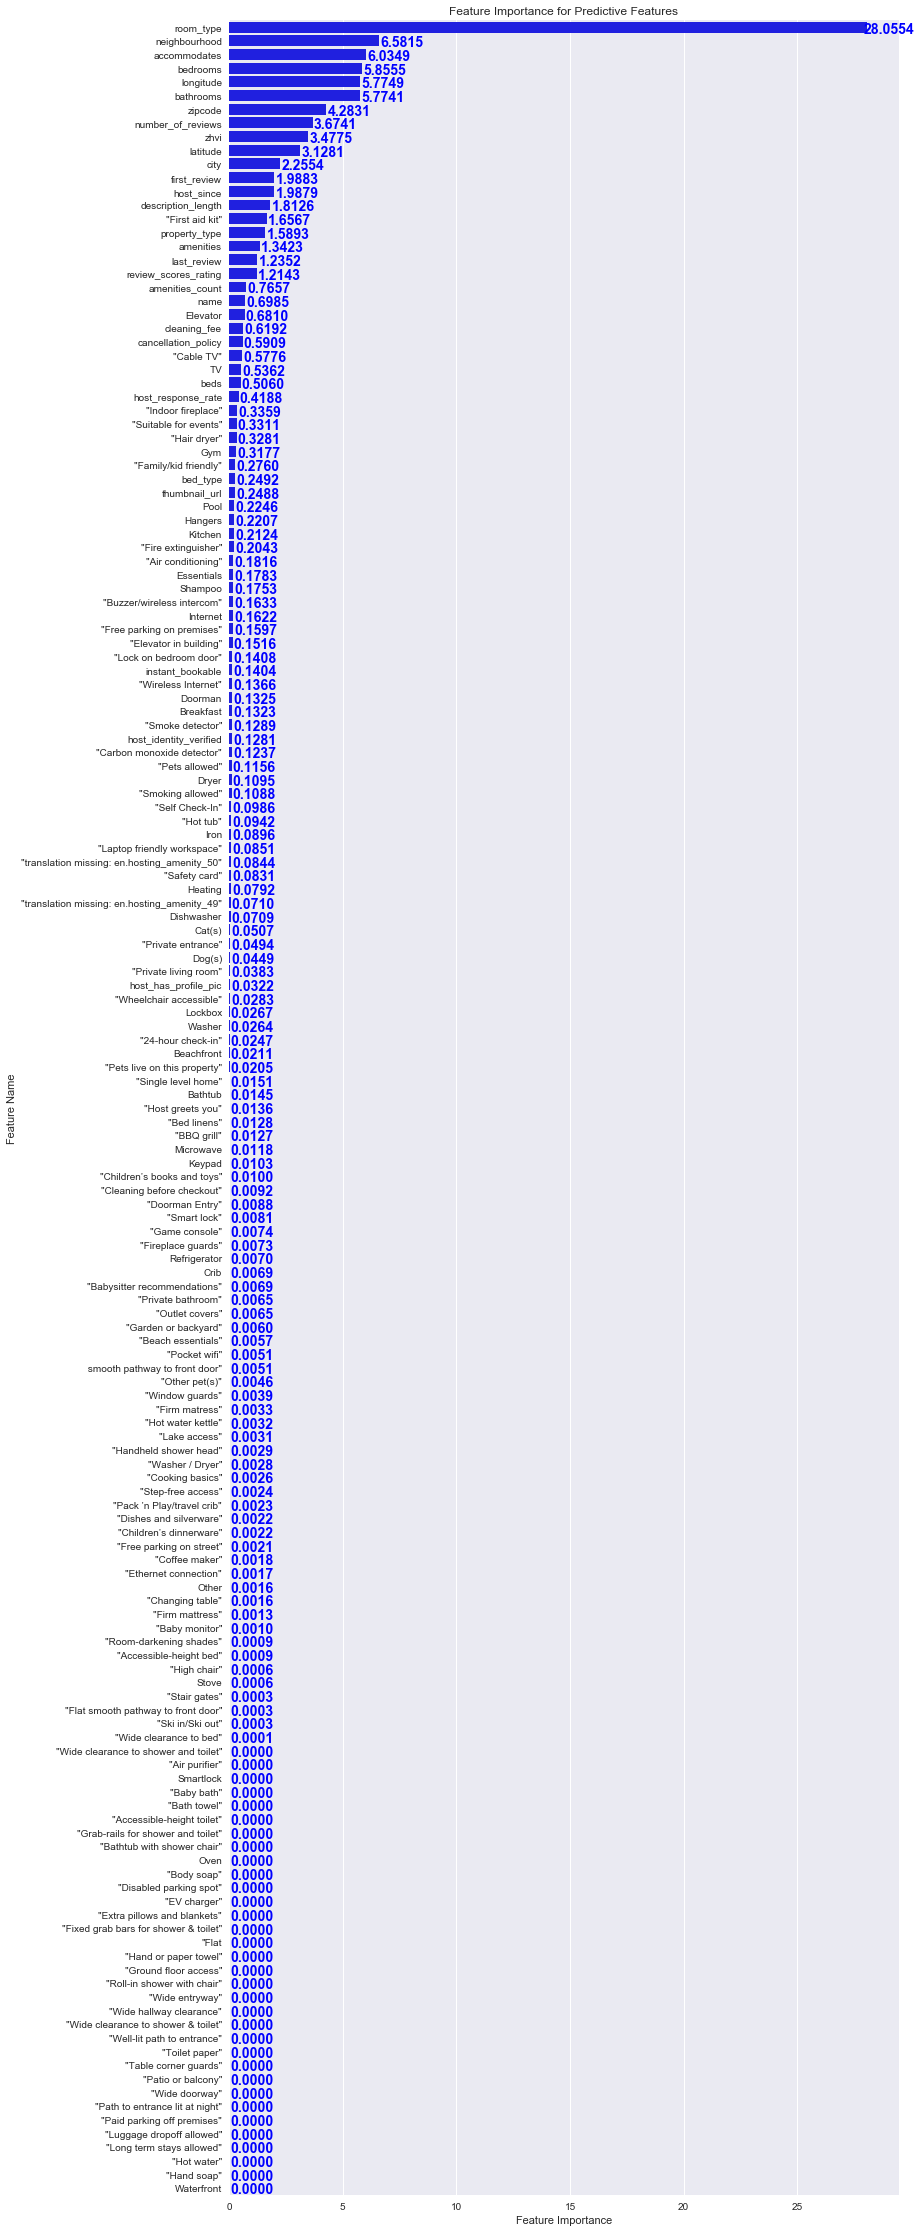

In [22]:
ax = plt.subplots(figsize=(12, 40))
sns.set_style("whitegrid")
ax = sns.barplot(x="feature_importance",y="Feature_name",data=importances, color='b')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature Name')
ax.set_title('Feature Importance for Predictive Features')

x = list(importances['feature_importance'])
myFormattedList = [ '%.4f' % elem for elem in x ]
reacts = ax.patches

for re,label in zip(reacts,myFormattedList):
    width = re.get_width()
    ax.text(width+1,re.get_y(),str(label),ha="center", va="top",fontsize = 14,fontweight='bold',color = 'blue')
plt.show()

plt.close()

Looking at the feature importance based on Catboost, below are top 10 most important predictors for airbnb prices - 
    1. Room_type
    2. Neighbourhood
    3. Accommodates
    4. Bedrooms
    5. longitude
    6. Bathrooms
    7. Zip-code
    8. Number_of_reviews
    9. Zhvi
    10. First_review
